In [7]:
# Test myanfis model
import myanfis
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

param = myanfis.fis_parameters(
    n_input=5,
    n_memb=5,
    batch_size=36,
    memb_func='gbellmf',
    optimizer='adam',
    loss='mse',
    n_epochs=80
)
fis = myanfis.ANFIS(n_input=param.n_input,
                    n_memb=param.n_memb,
                    batch_size=param.batch_size,
                    memb_func=param.memb_func,
                    name='ANFIS-DE'
                    )
# compile model
fis.model.compile(optimizer=param.optimizer,
                  loss=param.loss)

# Load dataset from CSV file
data = pd.read_csv("data.csv")

data = data.dropna()
# Variable assignment
X = data[['Glucose', 'INS', 'BMI', 'DPF', 'Age']].values
Y = data['Outcome'].values.reshape(-1, 1)
X
# Ensure that the number of samples is a multiple of the batch size
X = X[:len(X) // param.batch_size * param.batch_size]
Y = Y[:len(Y) // param.batch_size * param.batch_size]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# fit model
history = fis.fit(X_train, y_train,
                  epochs=param.n_epochs,
                  batch_size=param.batch_size,
                  validation_data=(X_test, y_test))

# eval model
fis.plotmfs(show_initial_weights=True)

loss_curves = pd.DataFrame(history.history)
loss_curves.plot(figsize=(8, 5))

fis.model.summary()
# get premise parameters
premise_parameters = fis.model.get_layer(
    'fuzzyLayer').get_weights()       # alternative

# get consequence paramters
bias = fis.bias
weights = fis.weights
conseq_parameters = fis.model.get_layer('defuzzLayer').get_weights()       # alternative

# Assuming 'y_pred' is the predicted labels and 'y_true' is the true labels
y_pred = fis.__call__(X_test)  # Assuming fis is your trained model
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Extract values from confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_binary)
sensitivity = recall_score(y_test, y_pred_binary)
specificity = tn / (tn + fp)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Sensitivity (Recall): {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')

NameError: name 'RuleLayer' is not defined

In [ ]:
#importing libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the dataset
dataset = pd.read_csv('data.csv')
dataset = dataset.dropna()
X = dataset[['Glucose', 'INS', 'BMI', 'DPF', 'Age']].values
y = dataset['Outcome'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define triangular membership function with optimized parameters
def triangular_mf(x, a, b, c, ki, wi):
    a = (a + ki) - wi
    b = (b + ki) - wi
    c = (c + ki) - wi
    return max(min((x - a) / (b - a), (c - x) / (c - b)), 0)

def fitness(params):
    fuzzy_results_train = [evaluate_rules(features, params) for features in X_train]
    y_pred_train = [round(result) for result in fuzzy_results_train]
    
    acc = accuracy_score(y_train, y_pred_train)
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    return 1 - (acc * 0.33 + sensitivity * 0.33 + specificity * 0.34)

class HarrisHawkOptimization:
    def __init__(self, fitness_func, dim, n_hawks=30, n_iterations=100):
        self.fitness_func = fitness_func
        self.dim = dim
        self.n_hawks = n_hawks
        self.n_iterations = n_iterations
        self.hawks = np.random.uniform(0, 100, (self.n_hawks, self.dim))
        self.rabbit = None

    def _find_rabbit(self):
        self.rabbit = min(self.hawks, key=self.fitness_func)

    def _update_position(self, hawk):
        E1 = np.random.uniform(0, 1)
        E2 = np.random.uniform(0, 1)
        
        if E1 < 0.5:
            if E2 < 0.5:
                hawk = self.rabbit - np.random.uniform(0, 1) * abs(self.rabbit - hawk)
            else:
                hawk = self.rabbit + np.random.uniform(0, 1) * abs(self.rabbit - hawk)
        else:
            hawk = np.random.uniform(0, 100, self.dim)
        
        return hawk

    def optimize(self):
        for iteration in range(self.n_iterations):
            self._find_rabbit()
            for i in range(self.n_hawks):
                new_hawk = self._update_position(self.hawks[i])
                if self.fitness_func(new_hawk) < self.fitness_func(self.hawks[i]):
                    self.hawks[i] = new_hawk

# Fuzzy rule evaluation with optimized parameters
def evaluate_rules(features, params):
    Glucose, INS, BMI, DPF, Age = features
    ki, wi = params  # or ki = params[0], wi = params[1] if params is an array
    
    # Membership functions for each feature, adjusted based on ki and wi
    Ageyoung = triangular_mf(Age, 0, 30, 40, ki, wi)
    
    Glucoselow = triangular_mf(Glucose, 0, 85, 100, ki, wi)
    Glucosemedium = triangular_mf(Glucose, 85, 125, 160, ki, wi)
    Glucosehigh = triangular_mf(Glucose, 125, 180, 200, ki, wi)
    
    INSlow = triangular_mf(INS, 0, 100, 200, ki, wi)
    INSmedium = triangular_mf(INS, 100, 200, 400, ki, wi)
    INShigh = triangular_mf(INS, 200, 400, 600, ki, wi)
    
    BMIlow = triangular_mf(BMI, 0, 20, 30, ki, wi)
    BMImedium = triangular_mf(BMI, 20, 30, 40, ki, wi)
    BMIhigh = triangular_mf(BMI, 30, 40, 50, ki, wi)
    
    DPFlow = triangular_mf(DPF, 0, 0.3, 0.6, ki, wi)
    DPFmedium = triangular_mf(DPF, 0.3, 0.6, 1.0, ki, wi)
    DPFhigh = triangular_mf(DPF, 0.6, 1.0, 2.0, ki, wi)
    
    # Fuzzy rules
    DMverylow = max(Glucoselow, INSlow, BMIlow, DPFlow, Ageyoung)
    DMlow = max(Glucoselow, INSlow, BMIhigh, DPFlow, Ageyoung)
    DMmedium = max(Glucosemedium, INShigh, BMIhigh, DPFmedium, Ageyoung)
    DMhigh = max(Glucosehigh, INSmedium, BMIhigh, DPFhigh, Ageyoung)
    DMverylow = max(Glucoselow, INSlow, BMImedium, DPFlow, Ageyoung)

    # Aggregate into a single value for DM
    DM = max(DMverylow, DMlow, DMmedium, DMhigh)
    
    return DM

# Initialize HHO
hho = HarrisHawkOptimization(fitness, dim=2, n_hawks=30, n_iterations=100)  # Here dim=2 for ki and wi

# Run Optimization
hho.optimize()

# Get the best hawk (solution)
best_hawk = min(hho.hawks, key=fitness)
print("Best Parameters ki and wi: ", best_hawk)

# Test the classifier on the test set using optimized parameters
fuzzy_results_test = [evaluate_rules(features, best_hawk) for features in X_test]
y_pred_test = [round(result) for result in fuzzy_results_test]

# Calculate performance metrics
acc = accuracy_score(y_test, y_pred_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
sens = tp / (tp + fn)
spec = tn / (tn + fp)

print(f"Accuracy based on optimized parameters: {acc}")
print(f"Sensitivity based on optimized parameters: {sens}")
print(f"Specificity based on optimized parameters: {spec}")


Best Parameters ki and wi:  [113.82300466   7.83870658]
Accuracy based on optimized parameters: 0.6455696202531646
Sensitivity based on optimized parameters: 0.5555555555555556
Specificity based on optimized parameters: 0.6923076923076923


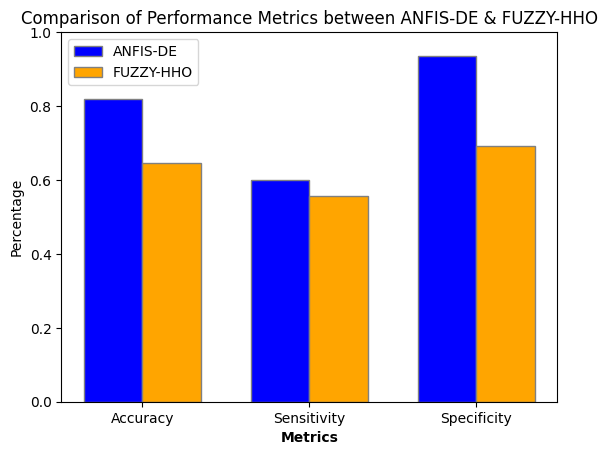

In [ ]:
import matplotlib.pyplot as plt
accuracy_set1 = accuracy
sensitivity_set1 = sensitivity
specificity_set1 = specificity

accuracy_set2 = acc
sensitivity_set2 = sens
specificity_set2 = spec

# Data preparation
metrics = ['Accuracy', 'Sensitivity', 'Specificity']
values_set1 = [accuracy_set1, sensitivity_set1, specificity_set1]
values_set2 = [accuracy_set2, sensitivity_set2, specificity_set2]

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(metrics))
r2 = [x + bar_width for x in r1]

# Plotting the grouped bar chart
plt.bar(r1, values_set1, color='blue', width=bar_width, edgecolor='grey', label='ANFIS-DE')
plt.bar(r2, values_set2, color='orange', width=bar_width, edgecolor='grey', label='FUZZY-HHO')

# Adding labels
plt.xlabel('Metrics', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(metrics))], metrics)
plt.ylim(0, 1)  
plt.ylabel('Percentage')
plt.title('Comparison of Performance Metrics between ANFIS-DE & FUZZY-HHO')
plt.legend()

# Show the plot
plt.show()
